In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import matplotlib

In [29]:
warnings.simplefilter("ignore")

In [30]:
threshold = 3

# Experimental data preparation

In [31]:
# read the efeatures and retained only the neurons selected during the preliminary quality checks
experiment_df = pd.read_csv('preprocessed_data_efeatures_selection.csv')

In [32]:
# reduce the attributes to the AP counts
experiment_df = experiment_df[['state',  'step current', 'stim dur', 'protocol', 
                               'AP_count', 'AP_count_before_stim', 'AP_count_after_stim']]

In [33]:
# rename columns
experiment_df.rename(columns={'stim dur':'duration', 'step current':'amplitude'}, inplace=True)

In [34]:
# rename state
experiment_df['state'].replace({'control':'normal'}, inplace=True)

In [35]:
# we are not interested 
# boundaries
experiment_df = pd.concat([
    experiment_df[(experiment_df['protocol'] == 'fi') & experiment_df['amplitude'].between(0, 300)],
    experiment_df[(experiment_df['protocol'] == 'rmih') & experiment_df['amplitude'].between(-200, -50)],
    experiment_df[(experiment_df['protocol'] == 'tburst') & (experiment_df['duration'] == 2000) & experiment_df['amplitude'].between(-300, -100)]
])

<AxesSubplot:xlabel='amplitude', ylabel='AP_count'>

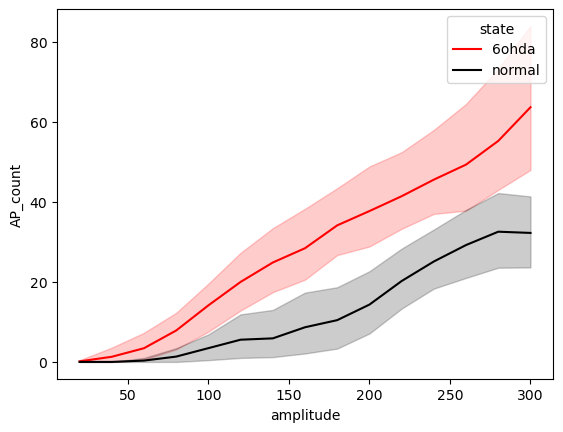

In [36]:
sns.lineplot(data=experiment_df[experiment_df['protocol'] == 'fi'], x='amplitude', y='AP_count', hue='state', palette=['red', 'black'])

<AxesSubplot:xlabel='amplitude', ylabel='AP_count_after_stim'>

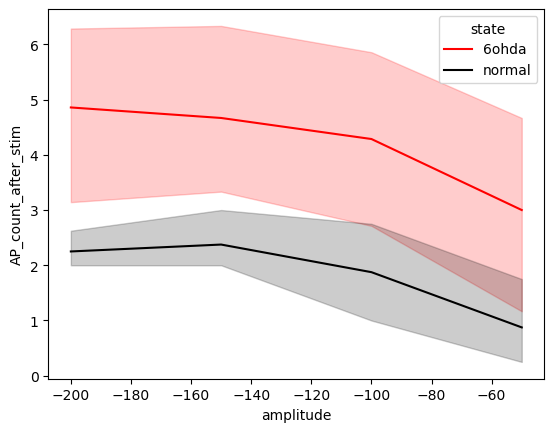

In [37]:
sns.lineplot(data=experiment_df[experiment_df['protocol'] == 'rmih'], x='amplitude', y='AP_count_after_stim', hue='state', palette=['red', 'black'])

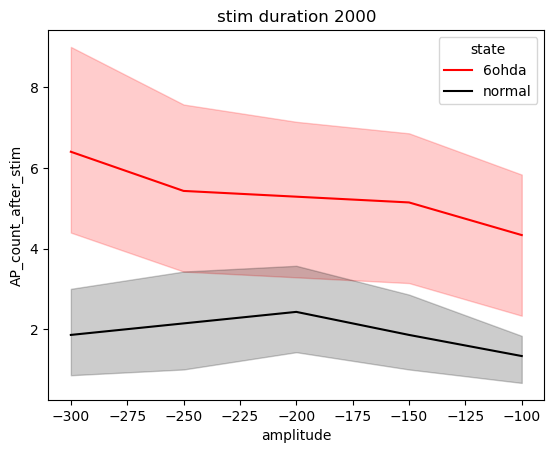

In [38]:
for dur in [2000]:
    plt.title('stim duration ' + str(dur))
    sns.lineplot(data=experiment_df[(experiment_df['protocol'] == 'tburst') & (experiment_df['duration'] == dur)], x='amplitude', y='AP_count_after_stim', hue='state', palette=['red', 'black'])
    plt.show()

# Simulation data preparation

In [39]:
df = pd.read_csv('qc_136.csv')                 #.set_index(['etype', 'cellid', 'seed'])
df_no_km = pd.read_csv('qc_136_no_km_100.csv') #.set_index(['etype', 'cellid', 'seed'])

In [40]:
df.shape, df_no_km.shape

((11322, 13), (11359, 13))

## Comparing curves for hyperpolarizing and depolarizing current steps

In [41]:
y_variable = {'fi':'AP_count', 'tburst':'AP_count_after_stim', 'rmih':'AP_count_after_stim' }

for _state in df['state'].unique():
    for _protocol, _y_variable in y_variable.items():
        # estimate the experimental curves
        exp_curve = experiment_df[(experiment_df['state']==_state)&(experiment_df['protocol']==_protocol)]
        exp_curve = exp_curve.groupby(['amplitude', 'duration'])[_y_variable].describe()[['count', 'mean', 'std']]
        exp_curve.dropna(inplace=True)

        # go over the simulated curves
        for k, g in df[(df['state']==_state)&(df['protocol']==_protocol)].groupby(['cellid', 'seed']):
            sim_curve = g.groupby(['amplitude', 'duration'])[_y_variable].describe()[['mean']]
            sim_curve.dropna(inplace=True)
            
            # only cases shown in the experiments
            sim_curve = sim_curve.loc[exp_curve.index, :]

            # max abs z-score
            max_err = ((sim_curve['mean'] - exp_curve['mean']) / (exp_curve['std'] + 0.001)).abs().max()

            if max_err > threshold:
                # remove if exceeding the threshold
                k += (_state, )

                df.drop(df[(df[['cellid', 'seed', 'state']]==k).all(axis=1)].index, inplace=True)

In [42]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

normal    149
6ohda      61
Name: state, dtype: int64

In [43]:
df.set_index(['etype', 'cellid', 'seed'], inplace=True)

## Comparing curves for depolarizing current steps with and without $K_M$

## Retuning bias current

In [44]:
pd.read_csv('qc_136.csv').groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -64.567800  1.693816
       rmih     -71.574423  2.340058
       tburst   -64.569993  1.693701
normal fi       -67.876068  0.867054
       rmih     -75.789869  1.575143
       tburst   -67.878207  0.867023

* 60% of bias current for 6ohda
* 40% of bias current for control

## Remove neurons did not pass the first quality check

In [46]:
# remove neurons did not pass the first quality check
# df_no_km = df_no_km.loc[df.index.drop_duplicates(), :]

## Remove individuals that fires spontaneously after $K_M$ blockade

In [47]:
# remove neurons that fires spontaneously after KM blockade
df_no_km = df_no_km.loc[df_no_km[df_no_km['AP_count_before_stim'] == 0].index.drop_duplicates(), :]

In [48]:
df_no_km.shape

(3410, 13)

In [49]:
df.groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -64.805750  1.607403
       rmih     -71.641620  2.407925
       tburst   -64.807941  1.607249
normal fi       -67.737409  0.753145
       rmih     -75.692809  1.544301
       tburst   -67.739562  0.753098

In [50]:
df_no_km.groupby(['state', 'protocol']).voltage_base.describe()[['mean', 'std']]

mean       std
state  protocol                     
6ohda  fi       -63.221944  1.965443
       rmih     -69.868455  2.850054
       tburst   -63.373537  1.853242
normal fi       -63.384634  1.469166
       rmih     -72.397957  2.327634
       tburst   -63.388574  1.503761

In [51]:
df.reset_index(inplace=True)
df_no_km.reset_index(inplace=True)

## Compare f-I curves between control and after $K_M$ blockade

In [55]:
# calculate the f-I curves for experiments
sim_curve = df[df['protocol']=='fi'].groupby(['state', 'amplitude', 'duration', 'cellid', 'seed'])[['AP_count']].mean().reset_index().set_index(['cellid', 'seed', 'state'])
sim_curve_no_km = df_no_km[df_no_km['protocol']=='fi'].groupby(['state', 'amplitude', 'duration', 'cellid', 'seed'])[['AP_count']].mean().reset_index().set_index(['cellid', 'seed', 'state'])

In [56]:
# p values threshold
alpha_accept = 0.01 
alpha_reject = 0.01

for k in sim_curve.index.drop_duplicates():
    # select curve for one neuron
    _sim_curve = sim_curve.loc[k, :].reset_index()[['amplitude', 'AP_count']].sort_values(by='amplitude')
    _sim_curve_no_km = sim_curve_no_km.loc[k, :].reset_index()[['amplitude', 'AP_count']].sort_values(by='amplitude')
    
    # compare normal vs xe991 curves
    p = stats.ranksums(_sim_curve.to_numpy()[:, 1], _sim_curve_no_km.to_numpy()[:, 1] )[1]        

    if  (k[2] == 'normal' and p >= alpha_reject) or (k[2] == '6ohda' and p < alpha_accept):
        df.drop(df[(df[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)
        df_no_km.drop(df_no_km[(df_no_km[['cellid', 'seed', 'state']] == k).all(axis=1)].index, inplace=True)

KeyError: 2641

In [54]:
df[['cellid', 'seed', 'state']].drop_duplicates()['state'].value_counts()

normal    149
6ohda      61
Name: state, dtype: int64

In [32]:
sim_curve = df[df['protocol']=='fi'].groupby(['state', 'amplitude'])[['AP_count']].mean().reset_index()
exp_curve = experiment_df[experiment_df['protocol']=='fi'].groupby(['state', 'amplitude'])[['AP_count']].mean().reset_index()

In [33]:
stats.ranksums(sim_curve[sim_curve.state == '6ohda'].to_numpy()[:, 2], exp_curve[exp_curve.state == '6ohda'].to_numpy()[:, 2] )[1]  

0.7557356175737271

In [34]:
stats.ranksums(sim_curve[sim_curve.state == 'normal'].to_numpy()[:, 2], exp_curve[exp_curve.state == 'normal'].to_numpy()[:, 2] )[1]  

0.2211020274342822

# Save models to files

In [35]:
def filter_models(filename, id_list, fileout=None):
    good_models = {}
    for k, v in np.load(filename, allow_pickle=True).tolist().items():
       if k in id_list: 
         good_models.update({k:v})
        
    if fileout:
        np.save(fileout, good_models, allow_pickle=True)

In [36]:
filter_models("hofv2_136_chk0.npy", \
              df[['etype', 'cellid', 'seed']].drop_duplicates().set_index(['etype', 'cellid', 'seed']).index.tolist(), \
              fileout="hofv2_136_chk1.npy")